# Import Necessary Packages

In [34]:
# Essential Packages
import pandas as pd 
import numpy as np
import os
import csv
import gc
import time
import warnings

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import matplotlib_venn as venn
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

# Natural Language Processing
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer  

# Feature Engingeering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Configurations
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
eng_stopwords = set(stopwords.words("english"))
warnings.filterwarnings("ignore")

lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

%matplotlib inline


# Loading the data

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Analyzing the data

In [8]:
# Lets take a look at what we're dealing with
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


As can be observed, there are 6 labels for every comment.

In [14]:
# Check for any missing values
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

There doesn't appear to be any missing values.

In [12]:
# Check percentage of training and testing data
no_rows_train = train.shape[0]
no_rows_test = test.shape[0]

total_rows = no_rows_train + no_rows_test

percent_train = no_rows_train/total_rows * 100
percent_test = no_rows_test/total_rows * 100

print("Percentage of training data: {:.2f}".format(percent_train), "%")
print("Percentage of testing data: {:.2f}".format(percent_test), "%")



Percentage of training data: 51.02 %
Percentage of testing data: 48.98 %


In [19]:
# Get the labels

categories = list(train.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [ ]:
# Comments with no label are considered to be clean comments.
# Creating seperate column in dataframe to identify clean comments.
# We use axis=1 to count row-wise and axis=0 to count column wise

rowSums = data_raw.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(data_raw))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(data_raw)-clean_comments_count))



In [21]:
#Get the number of comments in each category

counts = []
for category in categories:
    counts.append((category, train[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats



,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


# Visualization

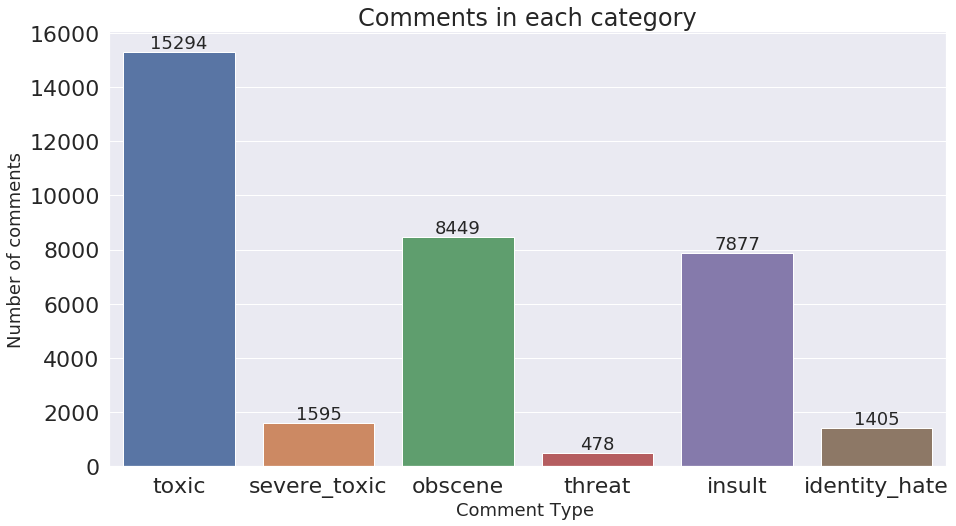

In [37]:
# Let's visualize the above stats

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, train.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

# adding the text labels
rects = ax.patches
labels = train.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()



We can observe the counts of each category.

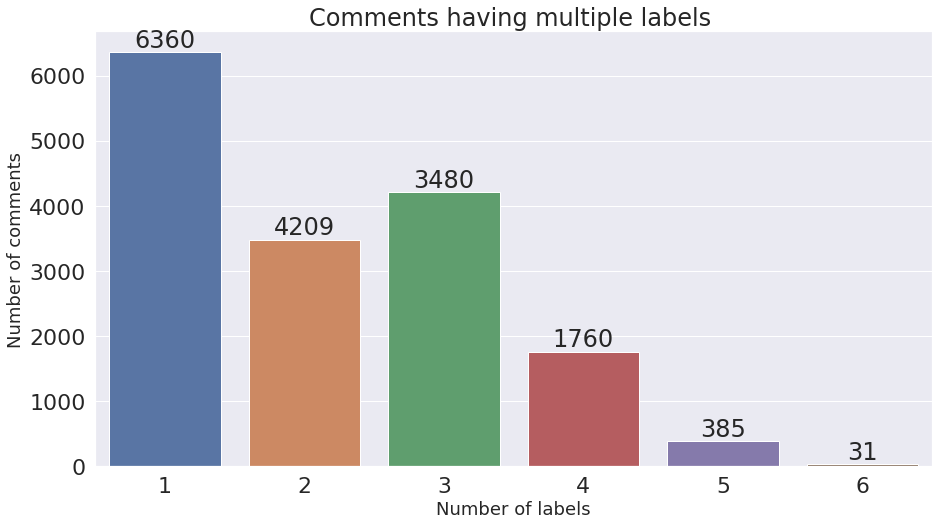

In [39]:
# Let's observe comments which have multiple labels

rowSums = train.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()



# Word Cloud

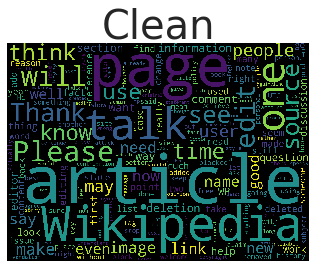

In [53]:
# Represent Word Cloud of clean comments
from wordcloud import WordCloud,STOPWORDS

subset = train[train.toxic==False]
text = subset.comment_text.values
cloud_clean = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_clean)# Same code can be used to generate wordclouds of other categories.

In [76]:
categories

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [73]:
# Get clean vs toxic comments.

x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098.0


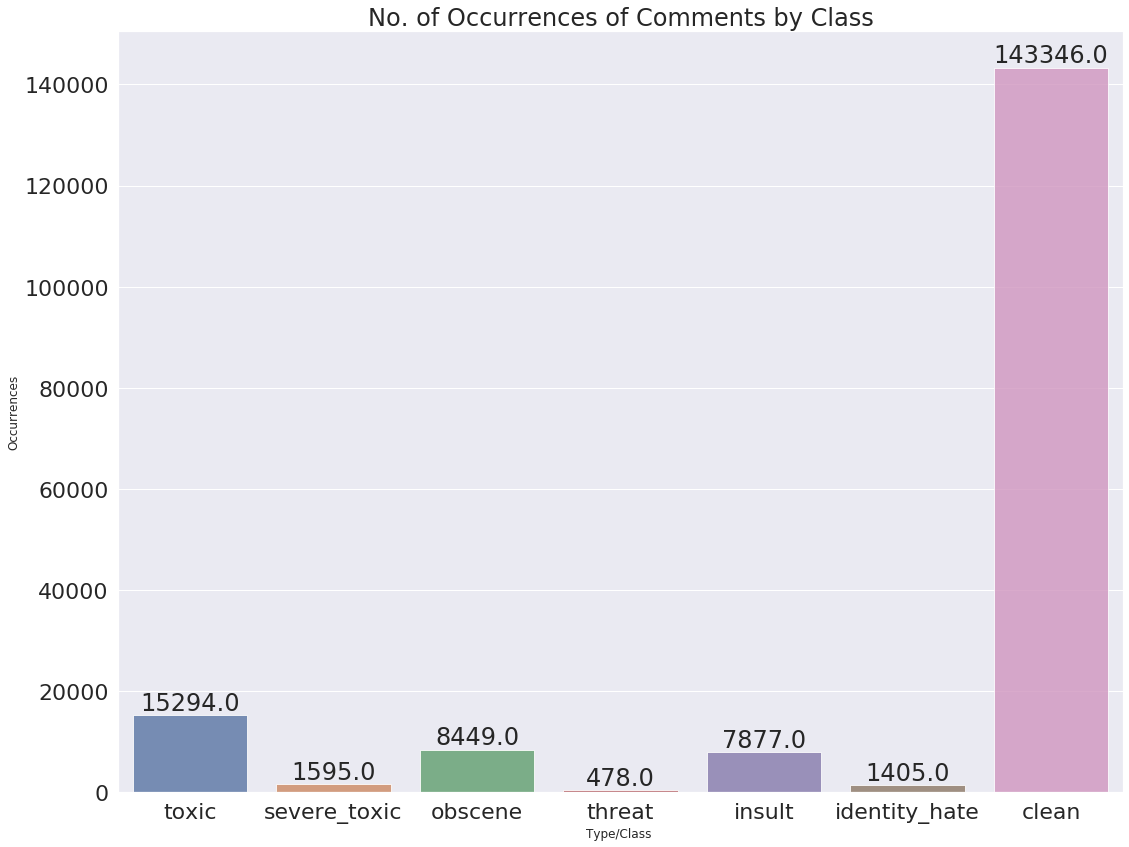

In [87]:
# Visualize clean vs toxic comments

x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(18,14))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("No. of Occurrences of Comments by Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type/Class ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()





As can be observed, there is an imbalance in categories and we may face class imbalance problems. This is because there are comments with multiple labels, as was observed above.
Aprroximately 90% of the comments are observed to be clean.

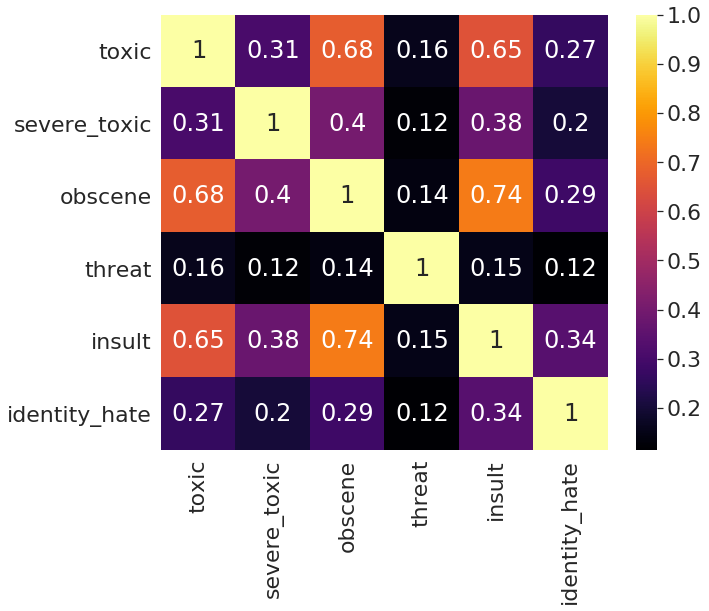

In [110]:
# Let's see how labels occur together using a correlation plot.



temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="inferno",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)



# Feature Engineering

In [80]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [81]:
## Indirect features

#Sentence count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))



In [82]:
# Derived features
# Word count percent in each comment

df['word_unique_percent']=df['count_unique_word']*100/df['count_word']

# Punctuation percent in each comment
df['punct_percent']=df['count_punctuations']*100/df['count_word']



In [83]:
# Separate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
# Join the labels
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)



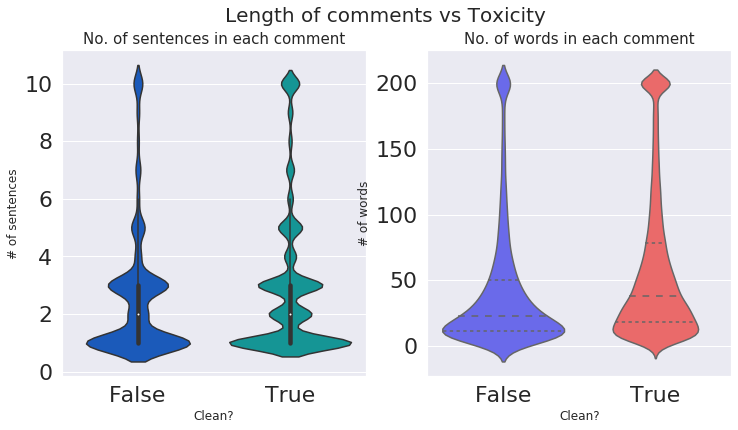

In [102]:
# Get the violin plot to check association of length and toxicity

train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
plt.suptitle("Length of comments vs Toxicity",fontsize=20)
sns.violinplot(y='count_sent',x='clean', palette="winter" ,data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("No. of sentences in each comment", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', palette="seismic", data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("No. of words in each comment", fontsize=15)

plt.show()

As can be observed, large number of sentences or words don't necessarily signify toxicity.

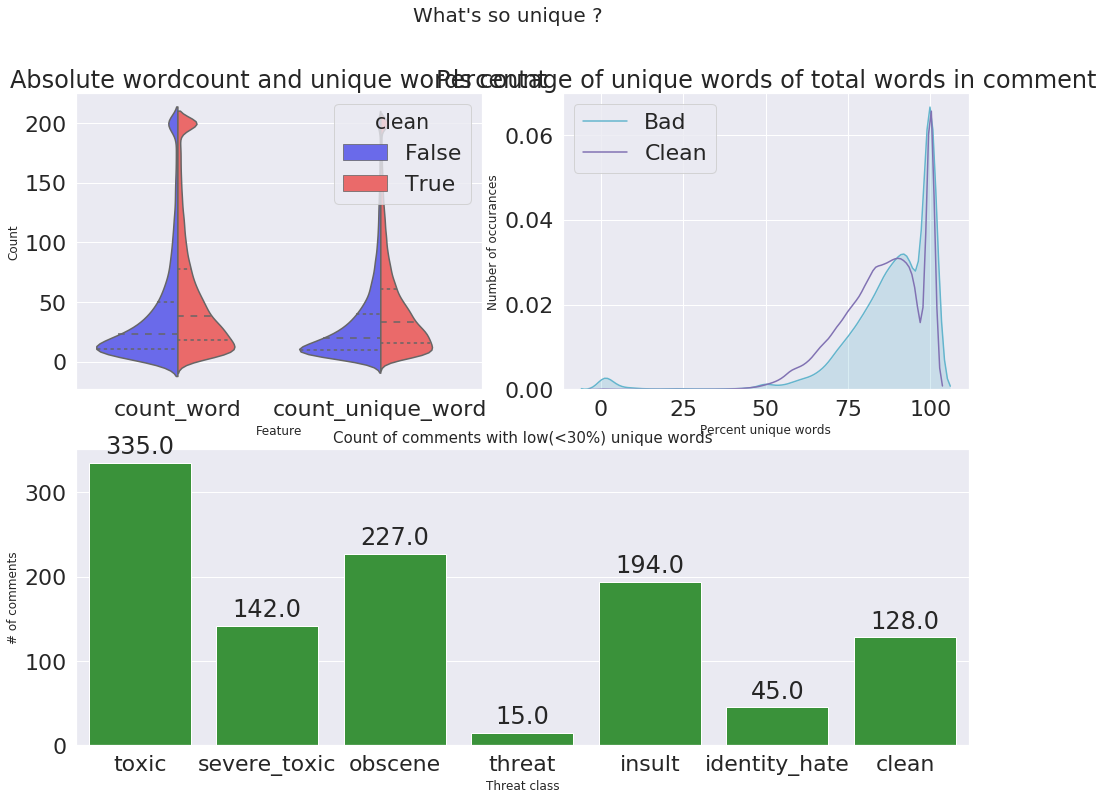

In [115]:
# Get the word count and the unique word count and label them according to their associated class

train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 40% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]



plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', palette="seismic" ,  data=temp_df,split=True,inner='quartile')
plt.title("Absolute wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='c')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean", color='m')
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[2])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()



We can observe based on the increase near the 0-10% mark that a large number of toxic comments have few unique words.

In [127]:
# Create custom count vectorizer.

#Leaky features
df['ip']=df["comment_text"].apply(lambda x: re.findall("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",str(x)))
#count of ip addresses
df['count_ip']=df["ip"].apply(lambda x: len(x))

#links
df['link']=df["comment_text"].apply(lambda x: re.findall("http://.*com",str(x)))
#count of links
df['count_links']=df["link"].apply(lambda x: len(x))

#article ids
df['article_id']=df["comment_text"].apply(lambda x: re.findall("\d:\d\d\s{0,5}$",str(x)))
df['article_id_flag']=df.article_id.apply(lambda x: len(x))

#username
##              regex for     Match anything with [[User: ---------- ]]
# regexp = re.compile("\[\[User:(.*)\|")
df['username']=df["comment_text"].apply(lambda x: re.findall("\[\[User(.*)\|",str(x)))
#count of username mentions
df['count_usernames']=df["username"].apply(lambda x: len(x))
#check if features are created
#df.username[df.count_usernames>0]

# Leaky Ip
cv = CountVectorizer()
count_feats_ip = cv.fit_transform(df["ip"].apply(lambda x : str(x)))


# Leaky usernames

cv = CountVectorizer()
count_feats_user = cv.fit_transform(df["username"].apply(lambda x : str(x)))



In [132]:
# Function to clean the corpus

def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    
    APPO = {
        "aren't" : "are not",
        "can't" : "cannot",
        "couldn't" : "could not",
        "didn't" : "did not",
        "doesn't" : "does not",
        "don't" : "do not",
        "hadn't" : "had not",
        "hasn't" : "has not",
        "haven't" : "have not",
        "he'd" : "he would",
        "he'll" : "he will",
        "he's" : "he is",
        "i'd" : "I would",
        "i'd" : "I had",
        "i'll" : "I will",
        "i'm" : "I am",
        "isn't" : "is not",
        "it's" : "it is",
        "it'll":"it will",
        "i've" : "I have",
        "let's" : "let us",
        "mightn't" : "might not",
        "mustn't" : "must not",
        "shan't" : "shall not",
        "she'd" : "she would",
        "she'll" : "she will",
        "she's" : "she is",
        "shouldn't" : "should not",
        "that's" : "that is",
        "there's" : "there is",
        "they'd" : "they would",
        "they'll" : "they will",
        "they're" : "they are",
        "they've" : "they have",
        "we'd" : "we would",
        "we're" : "we are",
        "weren't" : "were not",
        "we've" : "we have",
        "what'll" : "what will",
        "what're" : "what are",
        "what's" : "what is",
        "what've" : "what have",
        "where's" : "where is",
        "who'd" : "who would",
        "who'll" : "who will",
        "who're" : "who are",
        "who's" : "who is",
        "who've" : "who have",
        "won't" : "will not",
        "wouldn't" : "would not",
        "you'd" : "you would",
        "you'll" : "you will",
        "you're" : "you are",
        "you've" : "you have",
        "'re": " are",
        "wasn't": "was not",
        "we'll":" will",
        "didn't": "did not",
        "tryin'":"trying"
        }
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (') apostrophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)


In [133]:
# Cleaning the corpus before counting

corpus=merge.comment_text
clean_corpus=corpus.apply(lambda x :clean(x))


In [134]:
# Get the top words per class


### Unigrams -- TF-IDF 
# using settings recommended here for TF-IDF -- https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

#some detailed description of the parameters
# min_df=10 --- ignore terms that appear lesser than 10 times 
# max_features=None  --- Create as many words as present in the text corpus
    # changing max_features to 10k for memmory issues
# analyzer='word'  --- Create features from words (alternatively char can also be used)
# ngram_range=(1,1)  --- Use only one word at a time (unigrams)
# strip_accents='unicode' -- removes accents
# use_idf=1,smooth_idf=1 --- enable IDF
# sublinear_tf=1   --- Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf)


#temp settings to min=200 to facilitate top features section to run in kernals
#change back to min=10 to get better results
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])



#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

# modified for multilabel milticlass
def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs



#get top n for unigrams
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

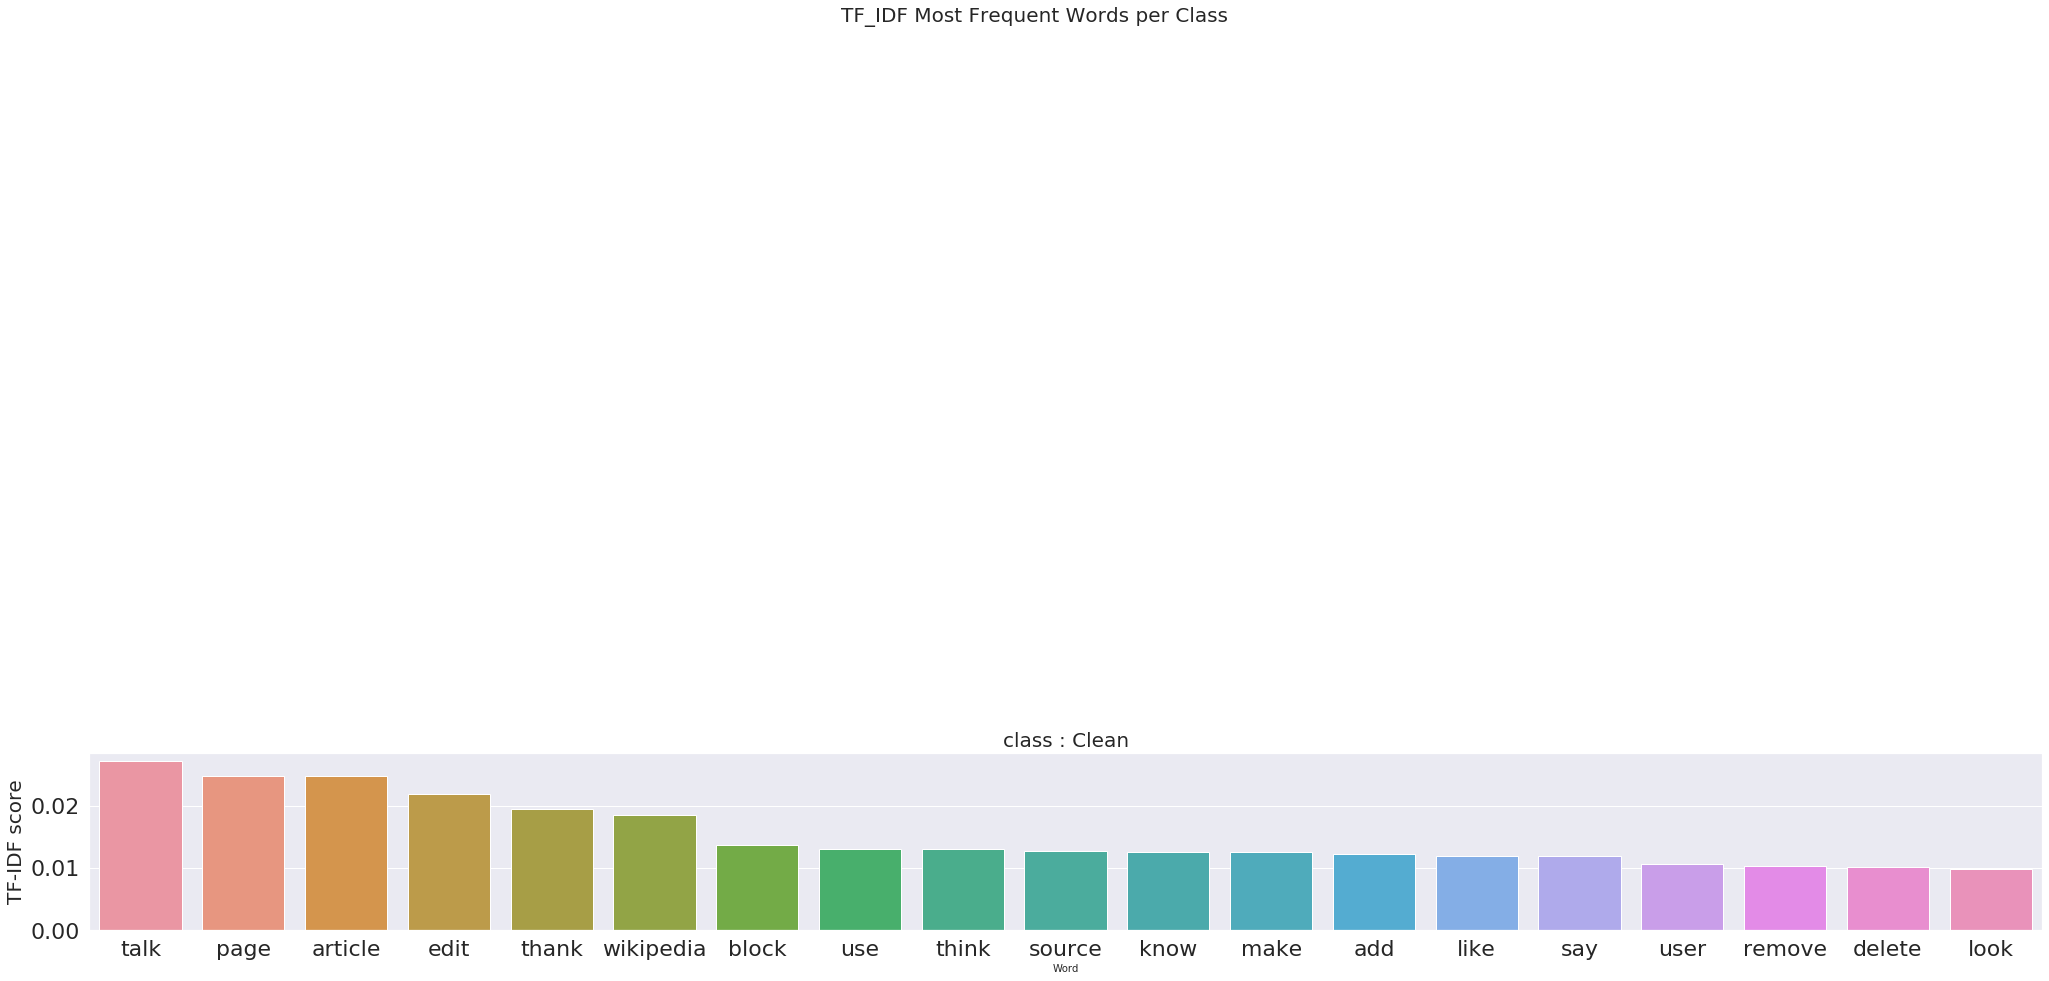

In [154]:
# Plotting the most frequent words in each class

plt.figure(figsize=(35,15))
plt.suptitle("TF_IDF Most Frequent Words per Class",fontsize=20)
gridspec.GridSpec(3,1)

plt.subplot2grid((4,2),(3,0),rowspan = 1, colspan=3)
sns.barplot(tfidf_top_n_per_lass[6].feature.iloc[0:19],tfidf_top_n_per_lass[6].tfidf.iloc[0:19])
plt.title("class : Clean",fontsize=20)
plt.xlabel('Word', fontsize=10)
plt.ylabel('TF-IDF score', fontsize=20)

plt.show()

In [155]:
# Credits https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda#Wordclouds---Frequent-words:
# This resource helped a lot for the EDA process of the project.